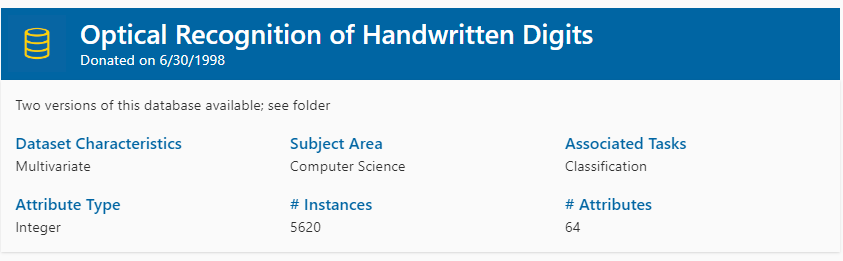


##  Data    
<a href="https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits">UCI Machine Learning</a>, 
    

## Objectives

After completing this lab you will be able to:

* Use <a href="https://snapml.readthedocs.io/en/latest/decision_trees.html">IBM snapML</a> algorithms to classify


**Additional Information**

We used preprocessing programs made available by NIST to extract normalized bitmaps of handwritten digits from a preprinted form. From a total of 43 people, 30 contributed to the training set and different 13 to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of 4x4 and the number of on pixels are counted in each block. This generates an input matrix of 8x8 where each element is an integer in the range 0..16. This reduces dimensionality and gives invariance to small distortions.

For info on NIST preprocessing routines, see M. D. Garris, J. L. Blue, G. T. Candela, D. L. Dimmick, J. Geist, P. J. Grother, S. A. Janet, and C. L. Wilson, NIST Form-Based Handprint Recognition System, NISTIR 5469, 1994.

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#load_dataset">Load the  data</a></li>
        <li><a href="#modeling">Modeling</a></li>
        <li><a href="#evaluation">Evaluation</a></li>
        <li><a href="#practice">Practice</a></li>
    </ol>
</div>
<br>
<hr>


## import packages


In [38]:
#!pip install snapml

In [39]:
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import scipy.optimize as opt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, ConfusionMatrixDisplay
%matplotlib inline 
import matplotlib.pyplot as plt

# the dataset in sklearn
from sklearn import datasets


import pickle # save the model

# suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data


In [40]:
## Load the digits dataset
digits = datasets.load_digits()

## Basic EDA

In [41]:
# Print the keys of the dataset
print(digits.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [42]:
# Print description
# print(digits.DESCR)

In [43]:
# Print the shape of the data 
print(digits.data.shape)

(1797, 64)


In [44]:
# Print the shape of the images 
print(digits.images.shape)

(1797, 8, 8)


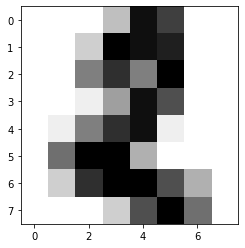

In [45]:
# Display digit at position 3
plt.imshow(digits.images[2], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

## Data pre-processing and selection, Train/Test


Let's set the Target and features

In [46]:
# Create feature and target arrays
X = digits.data
y = digits.target

Train test split the dataset

In [47]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=365, stratify=y)

Let's convert to an array so that sklearn find's it easy

In [48]:
# assign to the y variable
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [49]:
# assign the features
x_train = np.asarray(X_train)
x_test = np.asarray(X_test)

In [50]:
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (1437, 64) (1437,)
Test set: (360, 64) (360,)


## Feature scaling


In [51]:
scaler = StandardScaler() # scaler objecy
x_train = scaler.fit_transform(x_train) # allow the scaler object to learn the features and transform the training data
x_test =  scaler.transform(x_test) # apply the learned features on the test set

In [52]:
# scaled x_train
x_train[0:1]

array([[ 0.00000000e+00, -3.43522453e-01, -1.08776211e+00,
         5.18147431e-01,  5.00750353e-01, -8.50731595e-01,
        -4.14062562e-01, -1.18360259e-01, -6.14166374e-02,
        -6.23118365e-01, -1.35331965e+00,  1.00765120e+00,
         7.80339320e-01, -1.34980940e+00, -5.27415197e-01,
        -1.23461326e-01, -4.31180707e-02, -7.24233758e-01,
         2.59160002e-02,  1.54091713e+00, -8.33759940e-01,
        -1.26209985e+00, -5.56012746e-01, -1.10838322e-01,
        -3.73326696e-02, -7.82510131e-01,  1.11850575e+00,
         1.20945342e+00, -3.16262962e-01, -7.75552997e-01,
        -6.28330510e-01, -5.28331981e-02,  0.00000000e+00,
         1.89076623e-01,  1.31722859e+00,  9.31162753e-01,
        -3.83603266e-01,  8.96120344e-01, -2.60895231e-01,
         0.00000000e+00, -6.76445597e-02, -5.28955643e-01,
         1.39154365e+00,  5.74674359e-01, -1.22628912e+00,
         4.80034264e-01,  1.52388036e+00, -8.55950017e-02,
        -2.94608883e-02, -4.13726082e-01,  2.65284929e-0

In [53]:
# scaled x_test
x_test[0:1]

array([[ 0.        , -0.34352245, -0.87820129, -0.64707613,  0.50075035,
         0.90045205, -0.11264012, -0.11836026, -0.06141664, -0.62311837,
        -0.06457191,  0.75621957, -0.25679313,  0.79786025,  0.86475166,
        -0.12346133, -0.04311807,  0.10745823,  1.07496649, -0.00766328,
        -1.16080048, -1.26209985, -0.55601275, -0.11083832, -0.03733267,
         0.81519811,  1.11850575,  1.20945342,  0.98968496,  0.41439325,
        -0.62833051, -0.0528332 ,  0.        ,  1.33671382,  1.31722859,
         0.29519275, -0.04624837,  1.23687846,  0.58923277,  0.        ,
        -0.06764456,  0.12801001,  1.39154365, -0.35302501, -1.22628912,
         0.65471374,  1.05998541, -0.085595  , -0.02946089, -0.41372608,
         0.44317314,  1.03343218,  0.67005516,  1.20541442,  0.27148028,
        -0.19834726,  0.        , -0.31222961, -1.085746  , -0.67926529,
         0.0474108 ,  0.04759786, -0.50612065, -0.18603407]])

<div id="svm_snap">
    <h2>Build a RandomForest model with Snap ML</h2>
</div>


In [54]:
%%time
# import the RandomForest from Snap ML
from snapml import RandomForestClassifier as SnapForest

# in contrast to scikit-learn's LinearSVC, Snap ML offers multi-threaded CPU/GPU training of RandomForest
# to use the GPU, set the use_gpu parameter to True
# rf = SnapForest(class_weight='balanced', random_state=25, use_gpu=True, fit_intercept=False)

# to set the number of threads used at training time, one needs to set the n_jobs parameter
rf = SnapForest(n_estimators=75, criterion='gini', 
                            max_depth=150, min_samples_leaf=1, 
                            max_features='auto', bootstrap=True, 
                            n_jobs=1, random_state=10, verbose=False, 
                            use_histograms=False, hist_nbins=256, 
                            use_gpu=False, gpu_ids=[0], 
                            compress_trees=False)

# train an random Forest model using Snap ML
clf = rf.fit(x_train, y_train)

CPU times: total: 297 ms
Wall time: 670 ms


After being fitted, the model can then be used to predict new values:


In [55]:
yhat = clf.predict(x_test)
yhat[0:5]

array([6, 0, 7, 9, 0])

**Metrics**

In [56]:
Random_f1 = f1_score(y_test, yhat, average='weighted')
Random_accuracy = accuracy_score(y_test, yhat)
Random_precision = precision_score(y_test, yhat, average='micro')

print("Avg F1-score: %.4f" % Random_f1)
print("Accuracy: %.4f" % Random_accuracy)
print("Precision: %.4f" % Random_precision)

Avg F1-score: 0.9834
Accuracy: 0.9833
Precision: 0.9833


**Save the Random-Forest model:**

In [57]:
#save the trained model
pickle.dump(clf, open('OCR-RF(SnapML).pkl','wb'))

<h2 id="evaluation">Evaluation</h2>


In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [59]:
# classification report
print (classification_report(y_test, yhat,labels=np.unique(yhat)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        37
           2       1.00      1.00      1.00        35
           3       1.00      0.97      0.99        37
           4       1.00      0.97      0.99        36
           5       1.00      1.00      1.00        36
           6       1.00      1.00      1.00        36
           7       0.95      1.00      0.97        36
           8       0.92      0.94      0.93        35
           9       0.97      0.94      0.96        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



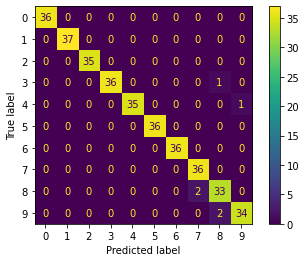

In [60]:
# confusion matrics
cm = confusion_matrix(y_test, yhat, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)
disp.plot()

plt.show()

### **Report**

In [61]:
metric = {
  "Accuracy": [str(round(Random_accuracy*100,2))+"%"],
  "F1 score" : [str(round(Random_f1*100,2))+"%"],
  "Precision": [str(round(Random_precision*100,2))+"%"]
}


Report = pd.DataFrame(metric)
Report = Report.rename(index={ 0:'Random Forest-SnapML'})

In [62]:
Report 

,Accuracy,F1 score,Precision
Random Forest-SnapML,98.33%,98.34%,98.33%


### **Now over to you TUNE the PARAMETERS to see if the ACCURACY and F1-SCORE will improve.**